In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os 
import PIL
import glob
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from source.network import NNClassifier

from source.helpme import get_gesture_dataset, load_imgs_from_folder, show_image, calculate_pad, show_history
from source.helpme import create_loader

#### Load the dataset

In [4]:
X, y = get_gesture_dataset(size=(64, 64), shuffle=True, gray_scale=False)

X.shape, y.shape

((2059, 3, 64, 64), (2059,))

#### Define transforms that will be applied to images

In [5]:
trs = transforms.Compose([
    transforms.ColorJitter(brightness=[0.9,1.1], contrast=[0.9,1.1], saturation=[0.9,1.1], hue=[-0.001,0.001]),
    transforms.ToTensor()
])

#### Create data loaders

In [6]:
# split the dataset in three parts: train, valid, test
train_size = 1700
valid_size = 100
test_size = len(X) - train_size - valid_size
print('train size =', train_size)
print('valid size =', valid_size)
print('test size =', test_size)

X_train = X[ : train_size]
y_train = y[ : train_size]

X_valid = X[train_size : train_size+valid_size]
y_valid = y[train_size : train_size+valid_size]

X_test = X[train_size+valid_size : ]
y_test = y[train_size+valid_size : ]

train size = 1700
valid size = 100
test size = 259


In [7]:
# create three data loaders: train, valid, test
train_loader = create_loader(X_train, y_train, batch_size=512, num_workers=1, shuffle=False, trs=trs)
valid_loader = create_loader(X_valid, y_valid, batch_size=len(X_valid), num_workers=1, shuffle=False, trs=None)
test_loader = create_loader(X_test, y_test, batch_size=len(X_test), num_workers=1, shuffle=False, trs=None)

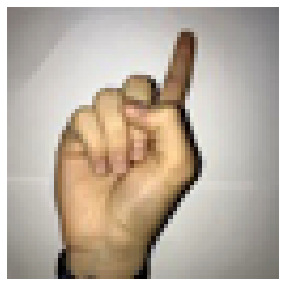

In [8]:
# show random image with applied transforms
for x_batch, y_batch in train_loader:
    show_image(x_batch[432])
    break

# Convolutional neural network

In [9]:
class Softmax_layer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        e = torch.exp(x - x.max(1, True)[0] )
        summ = e.sum(1, True)[0]
        return e / summ
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

In [10]:
calculate_pad(input_size = 64, kernel_size = 3, stride = 2, output_size = 32)

1

In [11]:
#################################
#  in_channels is not defined!  #
#################################

conv_net = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(8),
                               torch.nn.Dropout2d(0.03),
                               # 32x32x8
                               
                               torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(16),
                               torch.nn.Dropout2d(0.03),
                               # 16x16x16
                               
                               torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(32),
                               torch.nn.Dropout2d(0.03),
                               # 8x8x32
                               
                               torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               torch.nn.Dropout2d(0.03),
                               # 4x4x64
                               
                               torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(128),
                               torch.nn.Dropout2d(0.03),
                               # 2x2x128
                               
                               Flatten(),
                               torch.nn.Linear(512, 10),
                               Softmax_layer())

In [12]:
model = NNClassifier(conv_net, lr=1e-3, device='cuda')

In [13]:
model.fit_loader(train_loader, valid_loader, epochs=100, log_every_epoch=1)

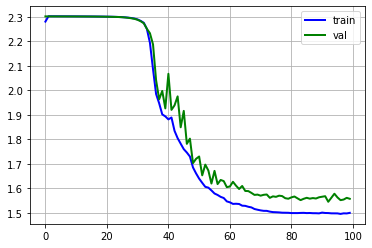

In [14]:
show_history(model.train_history, model.valid_history, width=2, fontsize=10)

In [15]:
model.evaluate_score(X_test, y_test)

0.722007722007722

# Testing on real data

Перед тем как перейти к тестированию на реальных данных, надо положить картинки в любом формате в папку source/real_data. Все что там находится можно удалить.

In [17]:
imgs = load_imgs_from_folder(os.path.join('source', 'real_data'), size=(64,64))

In [18]:
imgs.shape

(30, 3, 64, 64)

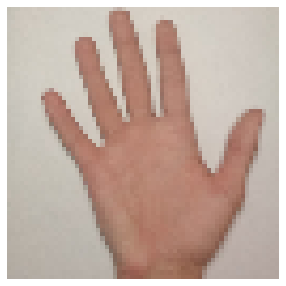

In [19]:
show_image(imgs[14])

In [20]:
model.predict(imgs)

array([4, 3, 3, 5, 5, 6, 5, 5, 5, 0, 0, 3, 3, 4, 5, 6, 5, 5, 5, 5, 0, 3,
       3, 4, 5, 3, 5, 8, 5, 5], dtype=int64)

#### Save the model

In [41]:
torch.save(conv_net.state_dict(), './my_network_1.pt')